In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7768388468824357389
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15134713447
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16901691601481543634
physical_device_desc: "device: 0, name: Quadro RTX 5000, pci bus id: 0000:65:00.0, compute capability: 7.5"
]


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import cv2
import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_df = pd.read_csv('./train.csv')
print("size of train_df:", len(train_df))

# 데이터 노이즈 수정
train_df.loc[train_df['id'] == 3896, 'artist'] = 'Titian'
train_df.loc[train_df['id'] == 3986, 'artist'] = 'Alfred Sisley'

DATAGEN_TRAIN = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    data_format="channels_last",
    validation_split=0.10
) # Train / Validation

# Generator의 instance 생성 (Train)
TRAIN_GENERATOR = DATAGEN_TRAIN.flow_from_dataframe(
    dataframe=train_df,
    x_col='img_path',
    y_col='artist',
    target_size=(244, 244),
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    subset="training"
)

VALID_GENERATOR = DATAGEN_TRAIN.flow_from_dataframe(
    dataframe=train_df,
    x_col='img_path',
    y_col='artist',
    target_size=(244, 244),
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    subset="validation"
)

size of train_df: 5911
Found 5320 validated image filenames belonging to 50 classes.
Found 591 validated image filenames belonging to 50 classes.


In [4]:
# ResNet50 모델 로드
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(244, 244, 3), pooling=None, input_tensor=None)

# 새로운 Fully Connected Layer 추가
x = base_model.output
x = Flatten()(x)
x = Dropout(0.2)(x) # 드롭아웃 추가
predictions = Dense(50, activation='softmax')(x)

#전체 모델 구성
model = Model(inputs=base_model.input, outputs=predictions)


# 모델 컴파일
model.compile(optimizer=Adam(lr=3e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [5]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
CP = ModelCheckpoint(filepath='resnet50_model/' + 'ResNet50-Sigmoid-{epoch:03d}-{loss:.4f}-{val_loss:.4f}.hdf5',
                     monitor='val_loss', verbose=1, save_best_only=True, mode='min'
)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=0.00005)
CALLBACK = [CP, LR]

In [6]:
# 모델 학습
history = model.fit(TRAIN_GENERATOR,
                    epochs=20,
                    validation_data=VALID_GENERATOR,
                    callbacks=CALLBACK,
)

Train for 167 steps, validate for 19 steps
Epoch 1/20
166/167 [============================>.] - ETA: 0s - loss: 4.1568 - accuracy: 0.2655
Epoch 00001: val_loss improved from inf to 4.02323, saving model to resnet50_model/ResNet50-Sigmoid-001-4.1548-4.0232.hdf5
167/167 [==============================] - 140s 838ms/step - loss: 4.1463 - accuracy: 0.2665 - val_loss: 4.0232 - val_accuracy: 0.0169
Epoch 2/20
166/167 [============================>.] - ETA: 0s - loss: 2.1866 - accuracy: 0.4465
Epoch 00002: val_loss did not improve from 4.02323
167/167 [==============================] - 129s 770ms/step - loss: 2.1837 - accuracy: 0.4468 - val_loss: 5.2451 - val_accuracy: 0.0169
Epoch 3/20
166/167 [============================>.] - ETA: 0s - loss: 1.6957 - accuracy: 0.5418
Epoch 00003: val_loss did not improve from 4.02323
167/167 [==============================] - 128s 767ms/step - loss: 1.6960 - accuracy: 0.5417 - val_loss: 4.9433 - val_accuracy: 0.0406
Epoch 4/20
166/167 [===================

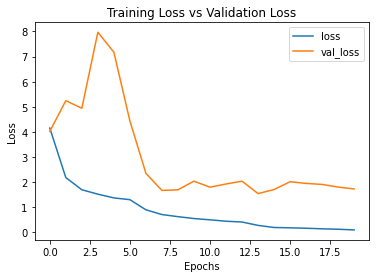

In [7]:
# 손실 그래프
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['loss', 'val_loss'])
plt.show()

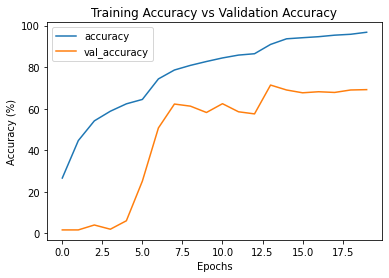

In [8]:
# 정확도 그래프
plt.plot([x * 100 for x in history.history['accuracy']])
plt.plot([x * 100 for x in history.history['val_accuracy']])
plt.title('Training Accuracy vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

In [6]:
# 최신 체크포인트 파일 찾기
checkpoint_files = glob.glob('resnet50_model/*.hdf5')
latest_checkpoint = max(checkpoint_files, key=os.path.getctime)

# 모델에 최신 가중치 로드
model.load_weights(latest_checkpoint)

# Validation 데이터에 대한 정확도 확인
val_loss, val_accuracy = model.evaluate(VALID_GENERATOR)
print('Validation Loss:', round(val_loss, 6))
print('Validation Accuracy:', round(val_accuracy, 3))

19/19 [==============================] - 27s 1s/step - loss: 1.5572 - accuracy: 0.6887
Validation Loss: 1.557201
Validation Accuracy: 0.689


In [7]:
test_df = pd.read_csv('test.csv')

TEST_GENERATOR = DATAGEN_TRAIN.flow_from_dataframe(
    dataframe=test_df,
    x_col='img_path',
    y_col='id',
    target_size=(244, 244),
    class_mode='raw',
    batch_size=32,
    shuffle=False,
)

TEST_GENERATOR.reset()

# 최신 체크포인트 파일 찾기
checkpoint_files = glob.glob('resnet50_model/*.hdf5')
latest_checkpoint = max(checkpoint_files, key=os.path.getctime)

print(latest_checkpoint)

# 모델에 최신 가중치 로드
model.load_weights(latest_checkpoint)

test_prediction = model.predict(TEST_GENERATOR, verbose=1)
display(test_prediction)

Found 12670 validated image filenames.
resnet50_model\ResNet50-Sigmoid-014-0.2804-1.5458.hdf5
396/396 [==============================] - 467s 1s/step


array([[1.6943183e-04, 9.9976087e-06, 2.2487135e-03, ..., 9.5472351e-05,
        2.9622573e-02, 1.8148499e-07],
       [2.5966885e-06, 3.3336843e-07, 8.2911938e-01, ..., 5.9192607e-06,
        2.8596651e-03, 1.4071844e-06],
       [2.1524486e-06, 1.4108102e-07, 3.0086076e-06, ..., 1.6191147e-05,
        2.0995556e-04, 1.6446934e-09],
       ...,
       [2.9334633e-06, 1.2780438e-07, 3.0439960e-02, ..., 7.6787357e-05,
        3.6677317e-04, 1.1691445e-08],
       [3.6544134e-04, 2.0242749e-06, 1.5355890e-04, ..., 2.1415049e-06,
        1.3356821e-02, 5.3659769e-06],
       [4.1638732e-06, 5.2197734e-08, 2.4576262e-05, ..., 3.4950481e-06,
        9.7072798e-01, 2.7390282e-10]], dtype=float32)

In [8]:
test_prediction = np.argmax(test_prediction, axis = 1)
test_prediction

array([10,  2,  9, ..., 33, 46, 48], dtype=int64)

In [9]:
test_prediction_df = pd.DataFrame(test_prediction, columns = ['artist'])
test_prediction_df

,artist
0,10
1,2
2,9
3,15
4,48
...,...
12665,10
12666,13
12667,33
12668,46


In [11]:
label_encoder = LabelEncoder()
artist_df = train_df.copy()
artist_le = label_encoder.fit_transform(artist_df['artist'].values)
artist_df['num'] = artist_le
artist_df = artist_df.drop('id', axis=1)
artist_df = artist_df.drop('img_path', axis=1)
artist_df.head()

,artist,num
0,Diego Velazquez,9
1,Vincent van Gogh,48
2,Claude Monet,7
3,Edgar Degas,10
4,Hieronymus Bosch,24


In [12]:
test_prediction_dic = test_prediction_df.to_dict()
test_prediction_values = test_prediction_dic['artist'].values()
test_prediction_list = list(test_prediction_values)
test_prediction_list[:5]

[10, 2, 9, 15, 48]

In [13]:
artist_df.set_index('num', inplace=True)
artist_df

,artist
num,
9,Diego Velazquez
48,Vincent van Gogh
7,Claude Monet
10,Edgar Degas
24,Hieronymus Bosch
...,...
40,Pieter Bruegel
37,Peter Paul Rubens
35,Paul Gauguin


In [14]:
artist_df = artist_df.sort_index()
artist_df

,artist
num,
0,Albrecht Du rer
0,Albrecht Du rer
0,Albrecht Du rer
0,Albrecht Du rer
0,Albrecht Du rer
...,...
49,William Turner
49,William Turner
49,William Turner


In [20]:
artist_info_dic = artist_df['artist'].to_dict()
artist_info_dic

{0: 'Albrecht Du rer',
 1: 'Alfred Sisley',
 2: 'Amedeo Modigliani',
 3: 'Andrei Rublev',
 4: 'Andy Warhol',
 5: 'Camille Pissarro',
 6: 'Caravaggio',
 7: 'Claude Monet',
 8: 'Diego Rivera',
 9: 'Diego Velazquez',
 10: 'Edgar Degas',
 11: 'Edouard Manet',
 12: 'Edvard Munch',
 13: 'El Greco',
 14: 'Eugene Delacroix',
 15: 'Francisco Goya',
 16: 'Frida Kahlo',
 17: 'Georges Seurat',
 18: 'Giotto di Bondone',
 19: 'Gustav Klimt',
 20: 'Gustave Courbet',
 21: 'Henri Matisse',
 22: 'Henri Rousseau',
 23: 'Henri de Toulouse-Lautrec',
 24: 'Hieronymus Bosch',
 25: 'Jackson Pollock',
 26: 'Jan van Eyck',
 27: 'Joan Miro',
 28: 'Kazimir Malevich',
 29: 'Leonardo da Vinci',
 30: 'Marc Chagall',
 31: 'Michelangelo',
 32: 'Mikhail Vrubel',
 33: 'Pablo Picasso',
 34: 'Paul Cezanne',
 35: 'Paul Gauguin',
 36: 'Paul Klee',
 37: 'Peter Paul Rubens',
 38: 'Pierre-Auguste Renoir',
 39: 'Piet Mondrian',
 40: 'Pieter Bruegel',
 41: 'Raphael',
 42: 'Rembrandt',
 43: 'Rene Magritte',
 44: 'Salvador Dali',


In [21]:
artist_name = []
for i in test_prediction_list:
    artist_name.append(artist_info_dic[i])
artist_name[:5]

['Edgar Degas',
 'Amedeo Modigliani',
 'Diego Velazquez',
 'Francisco Goya',
 'Vincent van Gogh']

In [22]:
submission_df = pd.read_csv("./sample_submission.csv")
submission_df = submission_df.drop('artist', axis=1)
submission_df.head()

,id
0,TEST_00000
1,TEST_00001
2,TEST_00002
3,TEST_00003
4,TEST_00004


In [23]:
submission_df['artist'] = artist_name
submission_df.head()

,id,artist
0,TEST_00000,Edgar Degas
1,TEST_00001,Amedeo Modigliani
2,TEST_00002,Diego Velazquez
3,TEST_00003,Francisco Goya
4,TEST_00004,Vincent van Gogh


In [24]:
submission_df.to_csv("resnet50_submission.csv", index=False)